# Author: Hemant

# The Sparks Foundation

# Stock Market Prediction using Numerical and Textual Analysis

# Objective: Create a hybrid model for stock price/performance prediction using numerical analysis of historical stock prices, and sentimental analysis of news headlines
# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import re

# Reading data file

In [2]:
##### Apple Dataset ####
df_stock = pd.read_csv('AAPL.csv')
df_stock.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2001-01-02,0.265625,0.272321,0.260045,0.265625,0.227738,452312000
1,2001-01-03,0.258929,0.297991,0.257813,0.292411,0.250703,817073600
2,2001-01-04,0.323940,0.330357,0.300223,0.304688,0.261229,739396000
3,2001-01-05,0.302455,0.310268,0.286830,0.292411,0.250703,412356000
4,2001-01-08,0.302455,0.303292,0.284598,0.295759,0.253573,373699200


In [3]:
#### News Headlline Dataset ####
df_headline = pd.read_csv('india-news-headlines.csv')
df_headline.head()

,publish_date,headline_category,headline_text
0,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,20010102,unknown,Fissures in Hurriyat over Pak visit
2,20010102,unknown,America's unwanted heading for India?
3,20010102,unknown,For bigwigs; it is destination Goa
4,20010102,unknown,Extra buses to clear tourist traffic


In [4]:
# Shape of both the datasets
print(df_stock.shape, df_headline.shape)

(2529, 7) (3424067, 3)


In [5]:
# Checking for null values
df_stock.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [6]:
# Dropping the invaluable column
df_headline.drop(columns = ['headline_category'], inplace = True)

In [7]:
# Dropping the duplicates
df_headline = df_headline.drop_duplicates()

# Converting the dataset according to the date 

In [8]:
df_stock['Date'] = pd.to_datetime(df_stock['Date'])
df_stock.set_index('Date', inplace = True)
df_stock

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2001-01-02,0.265625,0.272321,0.260045,0.265625,0.227738,452312000
2001-01-03,0.258929,0.297991,0.257813,0.292411,0.250703,817073600
2001-01-04,0.323940,0.330357,0.300223,0.304688,0.261229,739396000
2001-01-05,0.302455,0.310268,0.286830,0.292411,0.250703,412356000
2001-01-08,0.302455,0.303292,0.284598,0.295759,0.253573,373699200
...,...,...,...,...,...,...
2011-01-14,12.353214,12.445714,12.301429,12.445714,10.670520,308840000
2011-01-18,11.768571,12.312857,11.642857,12.166071,10.430766,1880998000
2011-01-19,12.441071,12.450000,12.031429,12.101429,10.375341,1135612800


In [9]:
df_headline['publish_date'] = df_headline['publish_date'].astype(str)
df_headline = df_headline.groupby(['publish_date'])['headline_text'].apply(lambda x : ','.join(x)).reset_index()
df_headline['publish_date'] = pd.to_datetime(df_headline['publish_date'])
df_headline.set_index('publish_date', inplace = True)
df_headline

,headline_text
publish_date,
2001-01-02,Status quo will not be disturbed at Ayodhya; s...
2001-01-03,"Powerless north India gropes in the dark,Think..."
2001-01-04,The string that pulled Stephen Hawking to Indi...
2001-01-05,Light combat craft takes India into club class...
2001-01-06,Light combat craft takes India into club class...
...,...
2020-12-27,#BigInterview! Dhritiman Chatterjee: Nobody da...
2020-12-28,Horoscope Today; 28 December 2020: Check astro...
2020-12-29,Man recovers charred remains of 'thief' from h...


# Combining the News Headline Dataset and the Apple Dataset

In [10]:
stock_market = pd.concat([df_stock, df_headline], axis = 1)
stock_market.dropna(axis = 0, inplace = True)
stock_market

,Open,High,Low,Close,Adj Close,Volume,headline_text
2001-01-02,0.265625,0.272321,0.260045,0.265625,0.227738,4.523120e+08,Status quo will not be disturbed at Ayodhya; s...
2001-01-03,0.258929,0.297991,0.257813,0.292411,0.250703,8.170736e+08,"Powerless north India gropes in the dark,Think..."
2001-01-04,0.323940,0.330357,0.300223,0.304688,0.261229,7.393960e+08,The string that pulled Stephen Hawking to Indi...
2001-01-05,0.302455,0.310268,0.286830,0.292411,0.250703,4.123560e+08,Light combat craft takes India into club class...
2001-01-08,0.302455,0.303292,0.284598,0.295759,0.253573,3.736992e+08,"Sangh Parivar; Babri panel up the ante,Frontru..."
...,...,...,...,...,...,...,...
2011-01-14,12.353214,12.445714,12.301429,12.445714,10.670520,3.088400e+08,"Cartoons,Yamla Pagla Deewana: Movie Review,SRK..."
2011-01-18,11.768571,12.312857,11.642857,12.166071,10.430766,1.880998e+09,"Top sex mistakes men make,No alcohol for 6-pac..."
2011-01-19,12.441071,12.450000,12.031429,12.101429,10.375341,1.135613e+09,"My ex doesn't want me: Pratik,Saali is not a g..."
2011-01-20,12.015357,12.082143,11.790000,11.881429,10.186723,7.647892e+08,"Neetu Chandra denies going panty-less!,Aishwar..."


In [11]:
stock_market.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2501 entries, 2001-01-02 to 2011-01-21
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Open           2501 non-null   float64
 1   High           2501 non-null   float64
 2   Low            2501 non-null   float64
 3   Close          2501 non-null   float64
 4   Adj Close      2501 non-null   float64
 5   Volume         2501 non-null   float64
 6   headline_text  2501 non-null   object 
dtypes: float64(6), object(1)
memory usage: 156.3+ KB


# Cleaning the data using Natural Language Processing (NLP)

In [12]:
length = len(stock_market)
sen = []
ps = PorterStemmer()
stopword = stopwords.words('english')
for i in range(0, length):
    text = re.sub('[^A-Za-z]', ' ', stock_market.iloc[i, stock_market.shape[1] - 1])
    text = text.lower()
    text = text.split()
    text = [ps.stem(word) for word in text if not word in set(stopword)]
    text = ' '.join(text)
    sen.append(text)
    
stock_market['headline_text'] = sen

# Calculating Sentiment Score

In [13]:
# Importing the necessary libraries for Sentiment Analysis
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

sid = SentimentIntensityAnalyzer()

stock_market['negative'] = stock_market['headline_text'].apply(lambda x : sid.polarity_scores(x)['neg'])
stock_market['positive'] = stock_market['headline_text'].apply(lambda x : sid.polarity_scores(x)['pos'])
stock_market['neutral'] = stock_market['headline_text'].apply(lambda x : sid.polarity_scores(x)['neu'])
stock_market['compound'] = stock_market['headline_text'].apply(lambda x : sid.polarity_scores(x)['compound'])

In [14]:
stock_market.head()

,Open,High,Low,Close,Adj Close,Volume,headline_text,negative,positive,neutral,compound
2001-01-02,0.265625,0.272321,0.260045,0.265625,0.227738,452312000.0,statu quo disturb ayodhya say vajpaye fissur h...,0.158,0.092,0.750,-0.9601
2001-01-03,0.258929,0.297991,0.257813,0.292411,0.250703,817073600.0,powerless north india grope dark think laxman ...,0.132,0.113,0.755,-0.5994
2001-01-04,0.323940,0.330357,0.300223,0.304688,0.261229,739396000.0,string pull stephen hawk india vajpaye give bi...,0.098,0.123,0.779,0.9432
2001-01-05,0.302455,0.310268,0.286830,0.292411,0.250703,412356000.0,light combat craft take india club class hawk ...,0.163,0.186,0.651,0.8402
2001-01-08,0.302455,0.303292,0.284598,0.295759,0.253573,373699200.0,sangh parivar babri panel ant frontrunn key us...,0.092,0.102,0.805,0.2500


# Saving the Processed Dataset

In [15]:
stock_market.drop(columns = ['headline_text'], inplace = True)
stock_market.index.name = 'Date'
stock_market.to_csv('Stock_market_dataset.csv')

# Reading the Processed Dataset

In [16]:
df = pd.read_csv('Stock_market_dataset.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume,negative,positive,neutral,compound
0,2001-01-02,0.265625,0.272321,0.260045,0.265625,0.227738,4.523120e+08,0.158,0.092,0.750,-0.9601
1,2001-01-03,0.258929,0.297991,0.257813,0.292411,0.250703,8.170736e+08,0.132,0.113,0.755,-0.5994
2,2001-01-04,0.323940,0.330357,0.300223,0.304688,0.261229,7.393960e+08,0.098,0.123,0.779,0.9432
3,2001-01-05,0.302455,0.310268,0.286830,0.292411,0.250703,4.123560e+08,0.163,0.186,0.651,0.8402
4,2001-01-08,0.302455,0.303292,0.284598,0.295759,0.253573,3.736992e+08,0.092,0.102,0.805,0.2500
...,...,...,...,...,...,...,...,...,...,...,...
2496,2011-01-14,12.353214,12.445714,12.301429,12.445714,10.670520,3.088400e+08,0.140,0.085,0.775,-0.9997
2497,2011-01-18,11.768571,12.312857,11.642857,12.166071,10.430766,1.880998e+09,0.151,0.078,0.770,-0.9998
2498,2011-01-19,12.441071,12.450000,12.031429,12.101429,10.375341,1.135613e+09,0.128,0.078,0.794,-0.9997
2499,2011-01-20,12.015357,12.082143,11.790000,11.881429,10.186723,7.647892e+08,0.129,0.086,0.784,-0.9996


In [17]:
df.set_index('Date', inplace = True)
df.head()

,Open,High,Low,Close,Adj Close,Volume,negative,positive,neutral,compound
Date,,,,,,,,,,
2001-01-02,0.265625,0.272321,0.260045,0.265625,0.227738,452312000.0,0.158,0.092,0.750,-0.9601
2001-01-03,0.258929,0.297991,0.257813,0.292411,0.250703,817073600.0,0.132,0.113,0.755,-0.5994
2001-01-04,0.323940,0.330357,0.300223,0.304688,0.261229,739396000.0,0.098,0.123,0.779,0.9432
2001-01-05,0.302455,0.310268,0.286830,0.292411,0.250703,412356000.0,0.163,0.186,0.651,0.8402
2001-01-08,0.302455,0.303292,0.284598,0.295759,0.253573,373699200.0,0.092,0.102,0.805,0.2500


# Data Visualisation

In [18]:
df.shape

(2501, 10)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2501 entries, 2001-01-02 to 2011-01-21
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2501 non-null   float64
 1   High       2501 non-null   float64
 2   Low        2501 non-null   float64
 3   Close      2501 non-null   float64
 4   Adj Close  2501 non-null   float64
 5   Volume     2501 non-null   float64
 6   negative   2501 non-null   float64
 7   positive   2501 non-null   float64
 8   neutral    2501 non-null   float64
 9   compound   2501 non-null   float64
dtypes: float64(10)
memory usage: 214.9+ KB


In [20]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume,negative,positive,neutral,compound
count,2501.000000,2501.000000,2501.000000,2501.000000,2501.000000,2.501000e+03,2501.000000,2501.000000,2501.000000,2501.000000
mean,3.090194,3.131518,3.042325,3.088833,2.648258,6.338680e+08,0.149458,0.096877,0.753674,-0.877047
std,3.027168,3.056782,2.988913,3.025129,2.593640,4.281523e+08,0.027236,0.028335,0.033773,0.412140
min,0.231964,0.235536,0.227143,0.234286,0.200869,3.934000e+07,0.000000,0.000000,0.244000,-0.999900
25%,0.412500,0.420536,0.405714,0.412857,0.353969,3.234280e+08,0.134000,0.085000,0.738000,-0.999100
50%,2.258929,2.297857,2.235000,2.256786,1.934890,5.225416e+08,0.150000,0.095000,0.754000,-0.997700
75%,4.960000,5.008929,4.866071,4.950357,4.244263,8.232364e+08,0.165000,0.106000,0.771000,-0.990400
max,12.441071,12.450000,12.301429,12.445714,10.670520,3.372970e+09,0.327000,0.756000,1.000000,0.999900


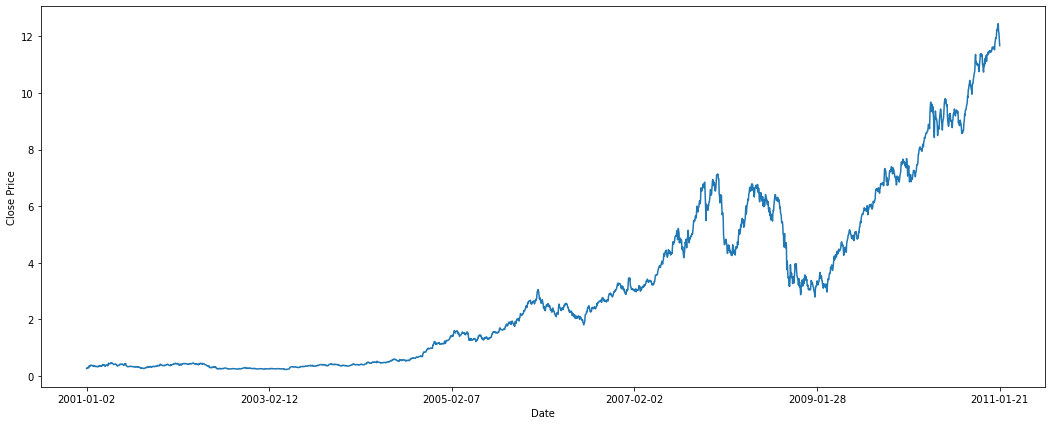

In [21]:
# Visualising Close price
plt.figure(figsize = (18, 7))
df['Close'].plot()
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

In [22]:
# Calculation weekly rolling mean
df.rolling(7).mean().head(10)

,Open,High,Low,Close,Adj Close,Volume,negative,positive,neutral,compound
Date,,,,,,,,,,
2001-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2001-01-10,0.293088,0.304687,0.281728,0.293368,0.251523,566364000.0,0.112429,0.096000,0.791429,-0.071200
2001-01-23,0.304408,0.319196,0.293208,0.307717,0.263826,627395200.0,0.096000,0.101857,0.802000,0.204271
2001-01-24,0.320033,0.329400,0.306282,0.318240,0.272848,613112000.0,0.088714,0.099286,0.811857,0.350114


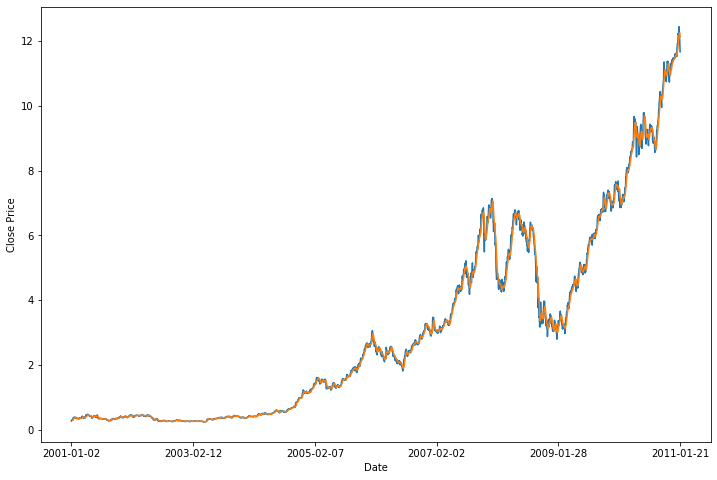

In [23]:
# Plotting the close price against weekly and monthly rolling mean of close price
plt.figure(figsize = (12, 8))
df['Close'].plot()
df['Close'].rolling(7).mean().plot()
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

# Using the adfuller test to check the stationarity of our data

In [24]:
from statsmodels.tsa.stattools import adfuller

In [25]:
def adfuller_test(price):
    test_result = adfuller(price)
    labels = ['ADF Test Statistic', 'p-value', '#Lags used', 'Number of Observation Used']
    for label, value in zip(labels, test_result):
        print(label+' : '+str(value))
    if test_result[1] <= 0.05:
        print('The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary.')
    else:
        print('Null hypothesis failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary.')
        
adfuller_test(df['Close'])

ADF Test Statistic : 1.3342018901225463
p-value : 0.9967937343861863
#Lags used : 19
Number of Observation Used : 2481
Null hypothesis failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary.


# Converting the Non-Stationary data into Stationary data

In [26]:
df['Difference'] = df['Close'] - df['Close'].shift(12)

In [27]:
# Again testing for stationarity
adfuller_test(df['Difference'].dropna())

ADF Test Statistic : -6.8363666333980815
p-value : 1.8381645796435194e-09
#Lags used : 26
Number of Observation Used : 2462
The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary.


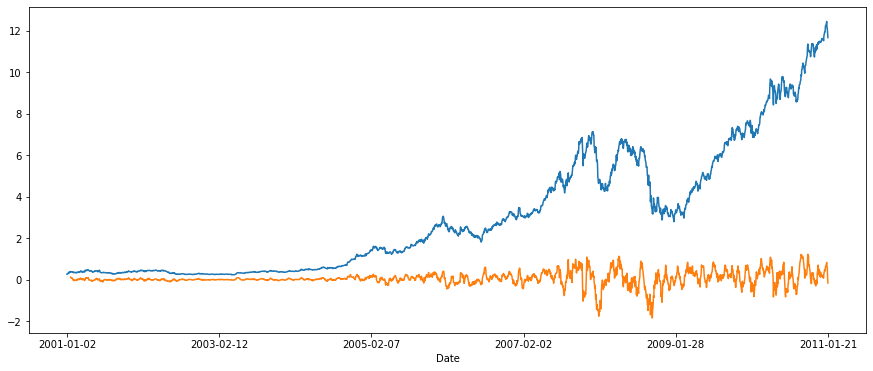

In [28]:
# Visualise the stationary data
plt.figure(figsize = (15,6))
df['Close'].plot()
df['Difference'].plot()
plt.show()

# Auto Regressive Model

In [29]:
# acf - autocorrelation function
# pacf - partial autocorrelation function
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

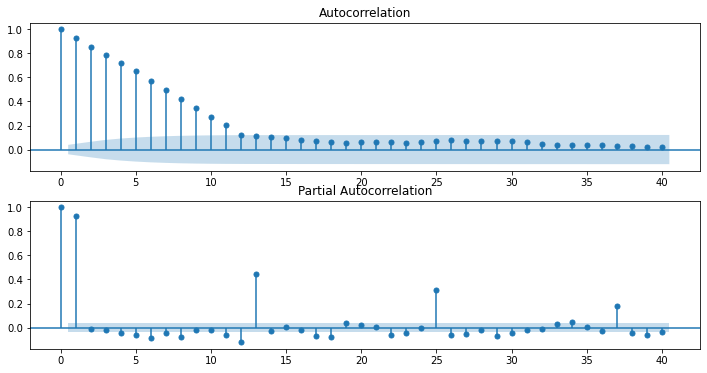

In [30]:
# Collecting p, q, d values from autocorrelation and partial autocorrelation graph
# p - AR model lag
# d - differencing
# q - MA lags
fig = plt.figure(figsize = (12, 6))
ax1 = fig.add_subplot(2, 1, 1)
fig = plot_acf(df['Difference'].dropna(), lags = 40, ax = ax1)
ax2 = fig.add_subplot(2, 1, 2)
fig = plot_pacf(df['Difference'].dropna(), lags = 40, ax = ax2)

# Prediction using SARIMAX

In [31]:
import statsmodels.api as sm

In [32]:
# From the graphs
# p --> 1
# q --> 1
model = sm.tsa.statespace.SARIMAX(df['Close'], order = (1, 2, 1), seasonal_order = (1, 2, 1, 12))
results = model.fit()

C:\Users\Hemant\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Hemant\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [33]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Close   No. Observations:                 2501
Model:             SARIMAX(1, 2, 1)x(1, 2, 1, 12)   Log Likelihood                1913.880
Date:                            Thu, 03 Feb 2022   AIC                          -3817.761
Time:                                    19:22:35   BIC                          -3788.691
Sample:                                         0   HQIC                         -3807.202
                                           - 2501                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0037      0.011      0.339      0.735      -0.018       0.025
ma.L1         -0.9990      0.008   -132.714      0.000      -1.014      -0.984
ar.S.L12      -0.4792      0.011    -42.315      0.000      -0.501      -0.457
ma.S.L12      -0.9998      0.771     -1.297      0.195      -2.511       0.511
sigma2         0.0120      0.009      1.300      0.194      -0.006       0.030
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              4789.82
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):             149.91   Skew:                            -0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [34]:
# Predicting the values
df['Forecasted Close Price'] = results.predict(start = 1, end = 2500, dynamic = False)

In [35]:
# Comparison between Actual and Predicted close price
predict = pd.DataFrame({"Close Price": df['Close'],"Prediction":df['Forecasted Close Price']})
predict.dropna(axis=0, inplace=True)
predict.head()

,Close Price,Prediction
Date,,
2001-01-03,0.292411,0.464844
2001-01-04,0.304688,0.319197
2001-01-05,0.292411,0.316965
2001-01-08,0.295759,0.280134
2001-01-09,0.306920,0.299107


In [36]:
# accuracy 
accuracy = (df['Forecasted Close Price'].sum() / df['Close'].sum()) * 100
print(accuracy.round(1), '%')

100.0 %


Text(0.5, 1.0, 'Comparison')

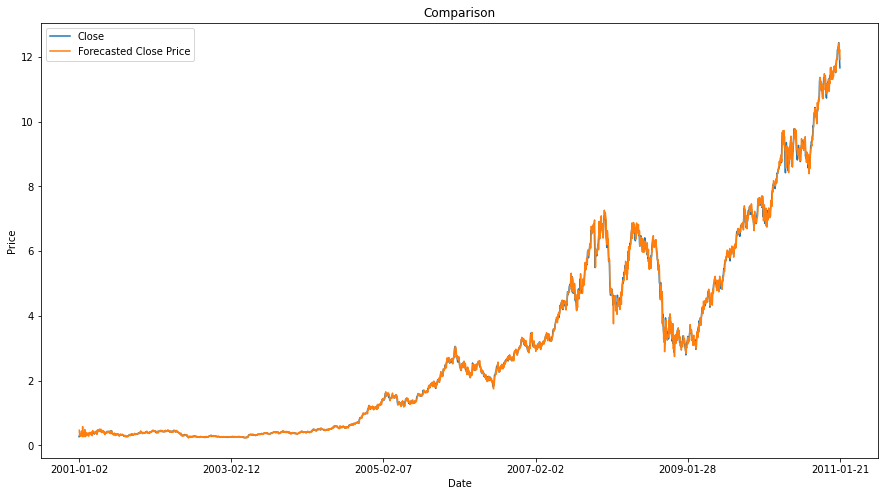

In [37]:
# Plotting the Actual values and Forecasted values
df[['Close', 'Forecasted Close Price']].plot(figsize = (15, 8))
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Comparison')

# Predicting Price using train_test_split method

In [43]:
from sklearn.model_selection import train_test_split

In [48]:
train, test = train_test_split(df[['Close']], test_size = 0.3, shuffle = False)
test

,Close
Date,
2008-01-31,4.834286
2008-02-01,4.776786
2008-02-04,4.701786
2008-02-05,4.620000
2008-02-06,4.357143
...,...
2011-01-14,12.445714
2011-01-18,12.166071
2011-01-19,12.101429


In [49]:
train.shape, test.shape

((1750, 1), (751, 1))

# Prediction

In [50]:
prediction = pd.DataFrame(results.predict(n_periods = 750), test.index)
prediction.columns = ["predicted_sales"]
test["predicted_sales"] = prediction
test

,Close,predicted_sales
Date,,
2008-01-31,4.834286,4.834606
2008-02-01,4.776786,4.640125
2008-02-04,4.701786,4.618317
2008-02-05,4.620000,4.692002
2008-02-06,4.357143,4.569239
...,...,...
2011-01-14,12.445714,12.357321
2011-01-18,12.166071,12.435613
2011-01-19,12.101429,12.121444


# Visualising predicted data

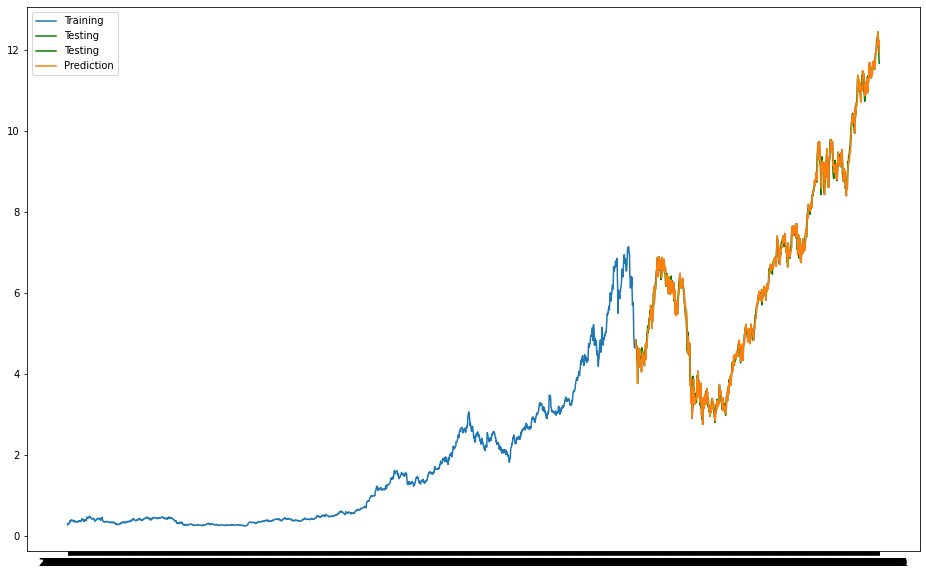

In [51]:
plt.figure(figsize = (16,10))
plt.plot(train, label = "Training")
plt.plot(test, label = "Testing",color="green")
plt.plot(prediction, label = "Prediction")
plt.legend()